In [1]:
!pip3 install mnist
!pip3 install minisom

# imports
import matplotlib.pyplot as plt
import numpy as np
import mnist
import scipy.misc
import math
import seaborn as sns

from matplotlib.colors import ListedColormap
from matplotlib import cm

from sklearn import datasets,metrics
from sklearn.datasets import fetch_20newsgroups, fetch_rcv1
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.manifold import TSNE
import umap
from minisom import MiniSom


from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, SpectralClustering, MiniBatchKMeans

from sklearn.metrics.pairwise import euclidean_distances

from joblib import Parallel, delayed
from tqdm import tqdm

!pip install ipython-autotime
%load_ext autotime

/home/adalmia1/anaconda3/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


time: 1.17 ms (started: 2021-02-05 17:43:47 -05:00)


In [2]:
# Load Digits dataset
digits = datasets.load_digits()
digits_n_samples = len(digits.images)
data = digits.images.reshape((digits_n_samples, -1))
digits_X_train, digits_X_test, digits_y_train, digits_y_test = train_test_split(data, digits.target, test_size=0.3, shuffle=True)


# Load full MNIST dataset
MNIST_X_train = mnist.train_images()
MNIST_X_train = MNIST_X_train.reshape((len(MNIST_X_train), -1)) 
MNIST_y_train = mnist.train_labels()

MNIST_X_test = mnist.test_images()
MNIST_X_test = MNIST_X_test.reshape((len(MNIST_X_test), -1)) 
MNIST_y_test = mnist.test_labels()

total_samples = len(MNIST_X_train) + len(MNIST_X_test)
blob_test_size = len(MNIST_X_test)/total_samples

# Load generated blobs dataset

blobs_X, blobs_y = datasets.make_blobs(n_samples=total_samples, centers=10, n_features=MNIST_X_train.shape[1], random_state=0)
blobs_X_train, blobs_X_test, blobs_y_train, blobs_y_test = train_test_split(blobs_X, blobs_y, test_size=blob_test_size, shuffle=True)

# Keep number of training samples consistent
assert (len(blobs_X_train) == len(MNIST_X_train)), print(len(blobs_X_train), len(MNIST_X_train))
assert (len(blobs_X_test) == len(MNIST_X_test)), print(len(blobs_X_test), len(MNIST_X_test))



#Load the 20NewsGroups
#Load the 20NewsGroups
vectorizer = TfidfVectorizer(min_df=5, stop_words='english') 

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_X_train = vectorizer.fit_transform(newsgroups_train.data).toarray()
newsgroups_y_train = newsgroups_train.target

newsgroups_test = fetch_20newsgroups(subset='test')
newsgroups_X_test = vectorizer.fit_transform(newsgroups_test.data).toarray()
newsgroups_y_test = newsgroups_test.target

print(newsgroups_X_train.shape)


#print(np.median(euclidean_distances(newsgroups_X_train)))
#print(np.median(euclidean_distances(newsgroups_X_test)))



#Load the RCV dataset
#rcv1_train = fetch_rcv1(subset='train')
#rcv1_X_train = newsgroups_train.data
#rcv1_y_train = newsgroups_train.target

#rcv1_test = fetch_rcv1(subset='test')
#rcv1_X_test = newsgroups_test.data
#rcv1_y_test = newsgroups_test.target




(11314, 25636)
time: 10.9 s (started: 2021-02-05 17:43:47 -05:00)


In [3]:
# k-Means clustering
def kmeans(X_train, X_test, y_train, y_test, n_clusters):
  kmeans = KMeans(n_clusters=n_clusters, random_state=2)
  y_pred_train = kmeans.fit_predict(X_train)
  train_centers = kmeans.cluster_centers_

  y_pred_test = kmeans.fit_predict(X_test)
  test_centers = kmeans.cluster_centers_

  return y_pred_train, y_pred_test, train_centers, test_centers
  

time: 5.87 ms (started: 2021-02-05 17:43:58 -05:00)


In [4]:
# Spectral clustering 
def spectral(X_train, X_test, y_train, y_test, n_clusters):
  #med = np.median(euclidean_distances(X_train))
  #print(med)
  spectral = SpectralClustering(n_clusters=n_clusters, random_state=0)
  y_pred_train = spectral.fit_predict(X_train)
  y_pred_test = spectral.fit_predict(X_test)

  return y_pred_train, y_pred_test


time: 23.4 ms (started: 2021-02-05 17:43:58 -05:00)


In [5]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

# Evaluation function
def evaluate(X, y, y_pred):
    print("Accurary Score: %0.3f" % purity_score(y, y_pred))
    print("Adjusted Mutual Information Score: %0.3f" % metrics.adjusted_mutual_info_score(y, y_pred))
    print("Adjusted Rand Index Score: %0.3f" % metrics.adjusted_rand_score(y, y_pred))
    print("Normalized Mutual Information Score: %0.3f" % metrics.normalized_mutual_info_score(y, y_pred))

    print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, y_pred))
    print("Completeness: %0.3f" % metrics.completeness_score(y, y_pred))
    print("V-measure: %0.3f" % metrics.v_measure_score(y, y_pred))
    #print(np.unique(y_pred))
    #print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, y_pred, sample_size=1000))
    print()




time: 20.7 ms (started: 2021-01-29 23:04:32 -05:00)


In [6]:
# dimension reduction


def pca_reduce(X_train, X_test, dim):
  pca = None
  if scipy.sparse.issparse(X_train):
    pca = TruncatedSVD(n_components=dim)
  else:
    pca = PCA(n_components=dim)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.fit_transform(X_test)

  return X_train_pca, X_test_pca


def tsne_reduce(X_train, X_test, dim):
  tsne = TSNE(n_components= dim)
  X_train_tsne = tsne.fit_transform(X_train)
  X_test_tsne = tsne.fit_transform(X_test)

  return X_train_tsne, X_test_tsne

def umap_reduce(X_train, X_test, dim):
  umapr = umap.UMAP(n_components=dim, n_jobs=1,  n_epochs = 800)
  X_train_umap = umapr.fit_transform(X_train)
  X_test_umap = umapr.fit_transform(X_test)
  return X_train_umap, X_test_umap


def kernel_pcarbf_reduce(X_train, X_test, dim):
  kernal_pca = KernelPCA(n_components=dim, kernel='rbf', gamma=  2*(1/19)**2)
  X_train_kpca = kernal_pca.fit_transform(X_train)
  X_test_kpca = kernal_pca.fit_transform(X_test)
  return X_train_kpca, X_test_kpca

def kernel_pcapoly_reduce(X_train, X_test, dim):
  kernal_pca = KernelPCA(n_components=dim, kernel='poly', gamma= 2*(1/19)**2)
  X_train_kpca = kernal_pca.fit_transform(X_train)
  X_test_kpca = kernal_pca.fit_transform(X_test)
  return X_train_kpca, X_test_kpca

def kernel_pcasig_reduce(X_train, X_test, dim):
  kernal_pca = KernelPCA(n_components=dim, kernel='sigmoid', gamma= 2*(1/19)**2)
  X_train_kpca = kernal_pca.fit_transform(X_train)
  X_test_kpca = kernal_pca.fit_transform(X_test)
  return X_train_kpca, X_test_kpca

def kernel_pcacos_reduce(X_train, X_test, dim):
  kernal_pca = KernelPCA(n_components=dim, kernel='cosine', gamma= 2*(1/19)**2)
  X_train_kpca = kernal_pca.fit_transform(X_train)
  X_test_kpca = kernal_pca.fit_transform(X_test)
  return X_train_kpca, X_test_kpca






def som_reduce(X_train, X_test, dim):

  grid_size_train = math.ceil(np.sqrt(X_train.shape[0])) 
  
  som = MiniSom(grid_size_train, grid_size_train, X_train.shape[1], sigma=4, learning_rate=0.5, neighborhood_function='triangle')
  som.random_weights_init(X_train)
  som.train(X_train, 1000, random_order=True, verbose=False)
  X_train_som = np.array(Parallel(n_jobs=1)(delayed(som.winner)(x) for x in tqdm(X_train))) 
  #X_train_som = np.array([som.winner(x) for x in X_train])


  grid_size_test = math.ceil(np.sqrt(len(X_test)))
  som = MiniSom(grid_size_test, grid_size_test, X_train.shape[1], sigma=4, learning_rate=0.5, neighborhood_function='triangle')
  som.random_weights_init(X_test)
  som.train(X_test, 1000, random_order=True, verbose=False)
  X_test_som = np.array(Parallel(n_jobs=1)(delayed(som.winner)(x) for x in tqdm(X_test))) 



  return X_train_som, X_test_som






def dimension_reduce(dimensions, X_train, X_test, y_train, y_test, reduce, n_clusters):
  y_pred_train, y_pred_test, _, _ = kmeans(X_train, X_test, y_train, y_test, n_clusters)
  print("Original KMeans")
  evaluate(X_train,y_train,y_pred_train) 

  y_pred_train, y_pred_test = spectral(X_train, X_test, y_train, y_test, n_clusters)
  print("Original Spectral")
  evaluate(X_train,y_train,y_pred_train) 
  
  
  for dim in dimensions:
    #reduction
    print("Reduce")
    X_train_pca, X_test_pca = reduce(X_train, X_test, dim)
    
    y_pred_train, y_pred_test, _, _ = kmeans(X_train_pca, X_test_pca, y_train, y_test, n_clusters)
    print("KMeans dimension reduce: " + str(dim))
    evaluate(X_train_pca,y_train,y_pred_train)

    y_pred_train, y_pred_test= spectral(X_train_pca, X_test_pca, y_train, y_test, n_clusters)
    print("Spectral dimension reduce: " + str(dim))
    evaluate(X_train_pca,y_train,y_pred_train)







time: 29.4 ms (started: 2021-01-29 23:04:32 -05:00)


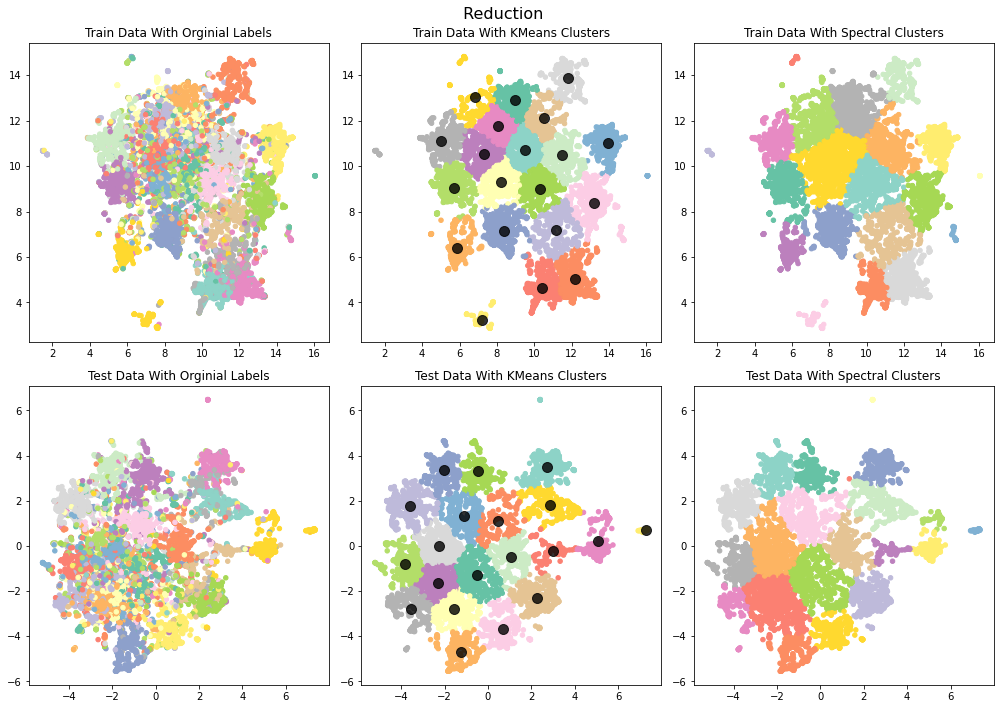

time: 5min 3s (started: 2021-01-29 23:04:32 -05:00)


In [7]:
# Visualization general

def visualize(X_train, X_test, y_train, y_test, reduce, title, n_clusters):
 
  colors = []
  colors += cm.get_cmap("Set3").colors
  colors += cm.get_cmap("Set2").colors
  my_cmap = ListedColormap(colors)
  
  X_train_r, X_test_r = reduce(X_train, X_test, 2)
 

  kmy_pred_train, kmy_pred_test, train_centers, test_centers = kmeans(X_train_r, X_test_r, y_train, y_test, n_clusters)
  spy_pred_train, spy_pred_test = spectral(X_train_r, X_test_r, y_train, y_test, n_clusters)

  
  fig=plt.figure(figsize=(14,10))
  # Train orginial labels
  plt.subplot(2, 3, 1)
  plt.gca().set_title('Train Data With Orginial Labels')
  plt.scatter(X_train_r[:, 0], X_train_r[:, 1], c= y_train, s=20, cmap=my_cmap)

  # Train kmeans labels
  plt.subplot(2, 3, 2)
  plt.gca().set_title('Train Data With KMeans Clusters')
  plt.scatter(X_train_r[:, 0], X_train_r[:, 1], c= kmy_pred_train, s=20, cmap=my_cmap)
  plt.scatter(train_centers [:, 0], train_centers [:, 1], c='black', s=100, alpha=0.8)

  # Train spectral labels
  plt.subplot(2, 3, 3)
  plt.gca().set_title('Train Data With Spectral Clusters')
  plt.scatter(X_train_r[:, 0], X_train_r[:, 1], c= spy_pred_train, s=20, cmap=my_cmap)


  # Test orginial labels
  plt.subplot(2, 3, 4)
  plt.gca().set_title('Test Data With Orginial Labels')
  plt.scatter(X_test_r[:, 0], X_test_r[:, 1], c= y_test, s=20,cmap=my_cmap)

  # Test kmeans labels
  plt.subplot(2, 3, 5)
  plt.gca().set_title('Test Data With KMeans Clusters')
  plt.scatter(X_test_r[:, 0], X_test_r[:, 1], c= kmy_pred_test, s=20,cmap=my_cmap)
  plt.scatter(test_centers[:, 0], test_centers[:, 1], c='black', s=100, alpha=0.8)

  # Test spectral labels
  plt.subplot(2, 3, 6)
  plt.gca().set_title('Test Data With Spectral Clusters')
  plt.scatter(X_test_r[:, 0], X_test_r[:, 1], c= spy_pred_test, s=20, cmap=my_cmap)

  fig.suptitle(title + " Reduction", fontsize=16)

  fig.tight_layout()
  fig.subplots_adjust(top=0.93)
  plt.show()



visualize(newsgroups_X_train , newsgroups_X_test , newsgroups_y_train, newsgroups_y_test, umap_reduce, "", 20)


In [8]:
# Digits reduction 
#dimension_reduce([48, 32, 16, 8, 4, 2], digits_X_train, digits_X_test, digits_y_train, digits_y_test, kernel_pcarbf_reduce, 10)
#visualize(digits_X_train, digits_X_test, digits_y_train, digits_y_test, som_reduce, "SOM", 10)

#visualize(digits_X_train, digits_X_test, digits_y_train, digits_y_test, tsne_reduce, "TSNE", 10)

time: 271 µs (started: 2021-01-29 23:09:35 -05:00)


In [9]:
# fetch 20 reduction 
#dimension_reduce([ 1000, 500, 300, 200, 100, 50, 20], newsgroups_X_train , newsgroups_X_test , newsgroups_y_train , newsgroups_y_test, 20)

#visualize(newsgroups_X_train , newsgroups_X_test , newsgroups_y_train, newsgroups_y_test, umap_reduce, "UMAP (Euclidean)", 20)

time: 22 ms (started: 2021-01-29 23:09:35 -05:00)


In [10]:
dimension_reduce([7500, 5000, 2500, 1000, 500, 250, 50, 20], newsgroups_X_train , newsgroups_X_test , newsgroups_y_train, newsgroups_y_test, umap_reduce, 20)

Original KMeans
Accurary Score: 0.363
Adjusted Mutual Information Score: 0.373
Adjusted Rand Index Score: 0.122
Normalized Mutual Information Score: 0.377
Homogeneity: 0.343
Completeness: 0.417
V-measure: 0.377

Original Spectral
Accurary Score: 0.309
Adjusted Mutual Information Score: 0.319
Adjusted Rand Index Score: 0.079
Normalized Mutual Information Score: 0.324
Homogeneity: 0.273
Completeness: 0.397
V-measure: 0.324

Reduce
KMeans dimension reduce: 7500
Accurary Score: 0.566
Adjusted Mutual Information Score: 0.503
Adjusted Rand Index Score: 0.370
Normalized Mutual Information Score: 0.506
Homogeneity: 0.488
Completeness: 0.524
V-measure: 0.506

Spectral dimension reduce: 7500
Accurary Score: 0.500
Adjusted Mutual Information Score: 0.499
Adjusted Rand Index Score: 0.288
Normalized Mutual Information Score: 0.502
Homogeneity: 0.456
Completeness: 0.560
V-measure: 0.502

Reduce
KMeans dimension reduce: 5000
Accurary Score: 0.600
Adjusted Mutual Information Score: 0.511
Adjusted Rand

In [11]:
#dimension_reduce([7500, 5000, 2500, 1000, 500, 250, 50, 20], newsgroups_X_train , newsgroups_X_test , newsgroups_y_train, newsgroups_y_test, umap_reduce, 20)

time: 512 µs (started: 2021-01-30 07:47:20 -05:00)


In [12]:
# rcv1 reduction
#dimension_reduce([ 1000, 500, 300, 200, 100, 50, 20], rcv1_X_train , rcv1_X_test , rcv1_y_train , rcv1_y_test, 103)
#visualize_pca(rcv1_X_train , rcv1_X_test , rcv1_y_train , rcv1_y_test, 103)
#visualize_tsne(rcv1_X_train , rcv1_X_test , rcv1_y_train , rcv1_y_test, 103, True)

time: 10.7 ms (started: 2021-01-30 07:47:20 -05:00)
